# **Implementing a Recurrent UNET**


In [ ]:
# Libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import matplotlib.pyplot as plt

In [ ]:
## Choose Kernel Initializer

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

## Approach to Implementation

To simplify the interpretability, I have divided the network into various blocks which are repeated throughout the architecture. There are mainly 3 types of blocks:

1. *Convolution block*: It is a set of two 2D convolution layers. We observe 5 such blocks in the encoder part of the U-Net/Recurrent-UNet. 

2. *Up-Convolution block*: It's counterpart in the decoder section of the network is the *Up-Convolution block* which is simply the upsampling of the input it gets. Adhering to the symmetry of the UNet, we observe 5 of these blocks on the decoder side.

2. *Recurrent block*: This is the block that defines the recurrent part of the network where it takes into account the output from the previous timestamp to make the current calculation. This block appears immediately after every instance of the above two blocks.


*Output of each convolution block is concatenated to the input of the corresponding up-convolution block.* 

**This implementation extends the approach introduced in the following repository: https://github.com/milesial/Pytorch-UNet**


In [ ]:
## 1. Convolution block definition

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

 

In [ ]:
## 2. Up-Convolution block definition

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

In [ ]:
## 3(a). Recurrent-block definition

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t # t timesteps
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

In [ ]:
## 3(b). Actually making the recurrent calls to the block defined above

class RCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1

## **UNET**

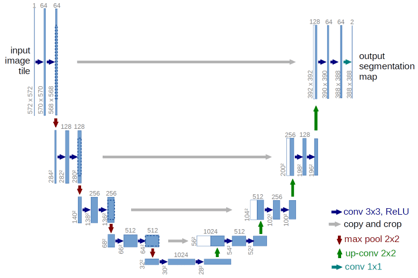

In [ ]:
class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

## **Recurrent UNET**

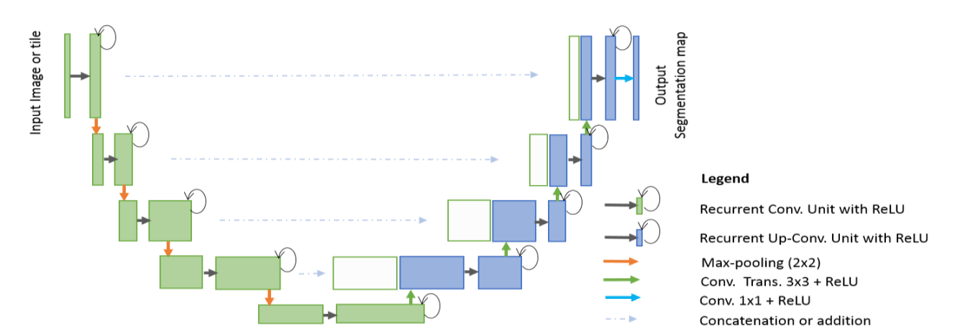

In [ ]:
## Reference: Alom, M.Z., Yakopcic, C., Hasan, M., Taha, T.M. and Asari, V.K., 2019. Recurrent residual U-Net for 
## medical image segmentation. Journal of Medical Imaging, 6(1), p.014006. 

class Rec_UNet(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(Rec_UNet,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RCNN1 = RCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RCNN2 = RCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RCNN3 = RCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RCNN4 = RCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RCNN5 = RCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RCNN5 = RCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RCNN4 = RCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RCNN3 = RCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RCNN2 = RCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        self.Conv_z = nn.Conv2d(512,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path

        #images = []

        x1 = self.RCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RCNN4(x4)

        #images.append(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RCNN5(d5)

        #images.append(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RCNN3(d3)

        #images.append(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RCNN2(d2)

        d1 = self.Conv_1x1(d2)

        z = self.Conv_z(d5)

        #images.append(d1)
        images = []
        images.append(d1)
        images.append(z)

        return images

## Fetching and Pre-processing Input Image

In [ ]:
from PIL import Image
from torchvision import transforms

net = Rec_UNet()
init_weights(net, init_type='normal')
x = Image.open("image0.bmp")
x.mode
x.getbands()

initialize network with normal


('R', 'G', 'B')

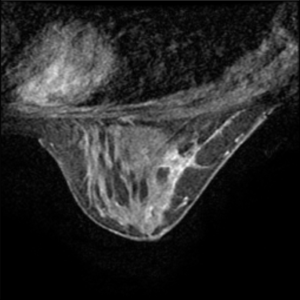

In [ ]:
t = transforms.Resize((300, 300))
t(x)

In [ ]:

trans = transforms.Compose([
        transforms.Resize((400, 400)),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

y = trans(x)
y.size()

torch.Size([3, 400, 400])

## Recurrent-Unet Output

In [ ]:
## Forward pass to the Recurrent UNet

l = net.forward(y[None, ...])

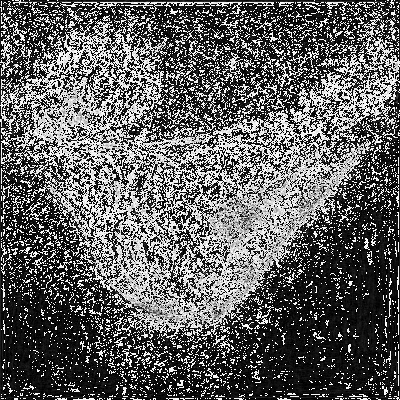

In [ ]:
## Final output

d = l[0]
d1 = d.squeeze(0)
trans1 = transforms.ToPILImage()
trans1(d1)

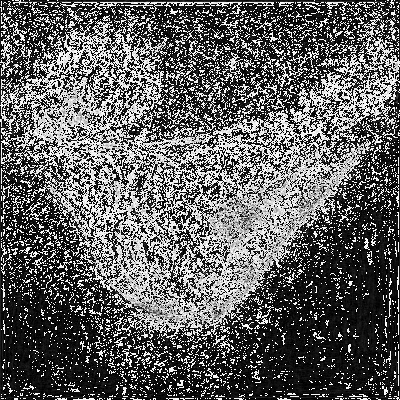

In [ ]:
## Output at 'd5'

z = l[1]
z1 = d.squeeze(0)
trans1 = transforms.ToPILImage()
trans1(z1)

## A coloured segmentation map
#plt.imshow(trans1(d1)) 

## UNET Output

In [ ]:
u = U_Net()
#init_weights(u)
d = u.forward(y[None, ...])

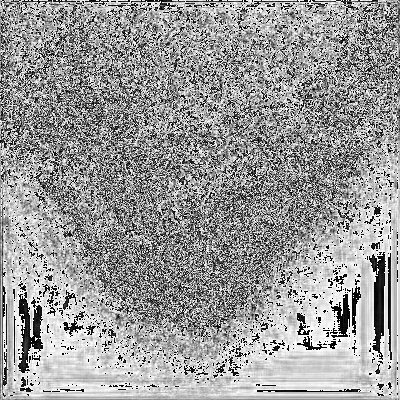

In [ ]:
d1 = d.squeeze(0)

trans1 = transforms.ToPILImage()
trans1(d1)
#plt.imshow(trans1(d1))

## References

* https://github.com/milesial/Pytorch-UNet
* Reference: Alom, M.Z., Yakopcic, C., Hasan, M., Taha, T.M. and Asari, V.K., 2019. Recurrent residual U-Net for medical image segmentation. Journal of Medical Imaging, 6(1), p.014006. 
